In [1]:
"""
 full braycurtis to compare fingerprints: 
 - dBm valus are adjusted from -95..-30 to 0-1
 - common APs are found 
 - difference between APs is taken, as in Fang et al [Calibration free approaches]
 - extra APs are added with their actual power or -95dBm when missing cf Beder & Klepal 2012
 - similarity function (braycurtis/correlation/cosine/...) is called 
 - thresholds for similarities returned are 0.25-0.35 for 2m
 - floors and clusters are hopefully at > 1.0  
 - notebook test results for precis-01 and precis-02 datasets 
"""

'\n full braycurtis to compare fingerprints: \n - dBm valus are adjusted from -95..-30 to 0-1\n - common APs are found \n - difference between APs is taken, as in Fang et al [Calibration free approaches]\n - extra APs are added with their actual power or -95dBm when missing cf Beder & Klepal 2012\n - similarity function (braycurtis/correlation/cosine/...) is called \n - thresholds for similarities returned are 0.25-0.35 for 2m\n - floors and clusters are hopefully at > 1.0  \n - notebook test results for precis-01 and precis-02 datasets \n'

In [80]:
from utils import *
import numpy as np
import sys, os, random
# from compare_locations import compare_locations

datadir = "../data.upb/precis/02-precis-redmi-pixel4a/"
pix_etaje = [ "0-pixel-04-06-2021_19-34-41.json"]  
red_etaje = [ "0-redmi-04-06-2021_19-33-47.json"]



In [116]:
datadir = "../data.upb/precis/01-precis-redmi-pixel4a/nowl/"
pix_etaje = [
"0-pixel-04-03-2021_15-32-38.json.gz",
"1-pixel-25-02-2021_21-16-46.json.gz",
"2-pixel-25-02-2021_16-27-45.json.gz",
"3-pixel-04-03-2021_16-18-50.json.gz",
"4-pixel-04-03-2021_16-43-50.json.gz",
"5-pixel-04-03-2021_17-11-32.json.gz",
"6-pixel-17-03-2021_12-52-29.json.gz",
"7-pixel-17-03-2021_13-14-36.json.gz"]

red_etaje = [
"0-redmi-04-03-2021_15-31-12.json.gz",
"1-redmi-25-02-2021_21-16-10.json.gz",
"2-redmi-25-02-2021_16-27-08.json.gz",
"3-redmi-04-03-2021_16-18-52.json.gz",
"4-redmi-04-03-2021_16-43-45.json.gz",
"5-redmi-04-03-2021_17-11-30.json.gz",
"6-redmi-17-03-2021_12-52-29.json.gz",
"7-redmi-17-03-2021_13-14-39.json.gz"]



In [2]:
import numpy as np
from scipy.spatial.distance import *
from scipy.stats import ks_2samp, chisquare
import copy 

def real_braycurtis(u, v, ex):
    """
    Compute the Bray-Curtis distance between two 1-D arrays.
    Bray-Curtis distance is defined as
    .. math::
       \\sum{|u_i-v_i|} / \\sum{|u_i+v_i|}
    The Bray-Curtis distance is in the range [0, 1] if all coordinates are
    positive, and is undefined if the inputs are of length zero.
    """
    l1_diff = abs(u - v)
    l1_sum = abs(u + v)
    
    return (abs(ex) + l1_diff.sum()) / (abs(ex) + l1_sum.sum())


def precalculate(c): # c is a collection
    """ creates new fields to speed up distance comparisons 
          c.ufingerprint['wifirssi'][mac] = average dBm 
    """
    ufingerprint = {}
    ufingerprint['wifirssi'] = {}
    for f in c['fingerprints']:
        if not "wifi" in f.keys():
            continue
        for mac in f["wifi"].keys():
            avg_pow = np.average(f["wifi"][mac]['rssi']) # each fingerprint (direction) counts the same
            if not mac in ufingerprint["wifirssi"].keys():
                ufingerprint["wifirssi"][mac] = [avg_pow] 
            else:
                ufingerprint["wifirssi"][mac].append(avg_pow)
    for mac in ufingerprint["wifirssi"].keys():
        ufingerprint["wifirssi"][mac] = \
            np.average(adjust_rssi(ufingerprint["wifirssi"][mac])) #each fingerprint (direction) counts the same
    c['ufingerprint'] = ufingerprint
                
def merge_wifi_fingerprints1(flist):
    if len(flist) == 1:
        return flist[0]
    fingerprint = copy.deepcopy(flist[0])
    for f2 in copy.deepcopy(flist[1:]):
        if not "wifi" in f2.keys():
            continue
        for mac in f2["wifi"].keys():
            if not mac in fingerprint["wifi"].keys():
                fingerprint["wifi"][mac] = f2["wifi"][mac]
            else:
                fingerprint["wifi"][mac]['rssi'].extend(f2["wifi"][mac]['rssi'])
            fingerprint["wifi"][mac]['rssi'].sort()    
    return fingerprint

def compare_locations(c1, c2, simil_method = braycurtis,  selection = 'Average', dif = True):
    # precalculated with average, adjust_rssi  
    wifi1 = c1['ufingerprint']['wifirssi']
    wifi2 = c2['ufingerprint']['wifirssi']      
    
    common_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
    # No APs in common -> similarity = 1
    if not common_aps:
        return 1.0

    if len(common_aps) * 5 <= len(wifi1.keys()) or len(common_aps) < 3:
        return 1.0

    aps1 = set(wifi1.keys()) - set(common_aps)
    aps2 = set(wifi2.keys()) - set(common_aps)
    rssi1 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    rssi2 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    nap = 0   #  
    
    if selection == 'First':
        for ap in common_aps:
            rssi1.append(wifi1[ap]['rssi'][0])
            rssi2.append(wifi2[ap]['rssi'][0])

        # Make an average of all RSSI values
    if selection == 'Average':
        for ap in common_aps:
            rssi1[nap] = wifi1[ap]
            rssi2[nap] = wifi2[ap]
            nap = nap + 1
            
    if selection == 'Median':
        for ap in common_aps:
            rssi1.append(np.median(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.median(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Mean':
        for ap in common_aps:
            rssi1.append(np.mean(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.mean(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Std':
        for ap in common_aps:
            rssi1.append(np.std(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.std(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Max':
        for ap in common_aps:
            rssi1.append(np.max(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.max(adjust_rssi(wifi2[ap]['rssi'])))
            
    if selection == 'KS':
        for ap in common_aps:
            _, p = ks_2samp(wifi1[ap]['rssi'], wifi2[ap]['rssi'])
            rssi1.append(p)
            rssi2.append(1.0)

    if (dif == True) and (selection != 'KS'):
        if len(rssi1) > nap:
            rssi1[nap] = rssi1[0]
            rssi2[nap] = rssi2[0]
        rssi1 = np.diff(rssi1, append=rssi1[0])
        rssi2 = np.diff(rssi2, append=rssi1[0])   

   
    """
    p1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), wifi1.keys())))
    p2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), wifi2.keys())))
    pc1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), common_aps)))
    pc2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), common_aps)))
    po1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), aps1)))
    po2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), aps2)))        
    iou = len(common_aps) / \
        (len(aps1) + len(aps2) + len(common_aps))
    """
        
    for ap in aps1:
        rssi1[nap] = 1.0*wifi1[ap]
        rssi2[nap] = adjust_rssi(-95.0)[0]
        nap = nap + 1
    for ap in aps2:
        rssi2[nap] = 1.0*wifi2[ap]
        rssi1[nap] = adjust_rssi(-95.0)[0]
        nap = nap + 1
        
    return simil_method(rssi1, rssi2)
    #return rssi1, rssi2



In [117]:
retaje = []
for e in red_etaje: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    for c in etaj:
        precalculate(c)
    retaje.append(etaj)

petaje = []
for e in pix_etaje: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    for c in etaj:
        precalculate(c)
    petaje.append(etaj)
    

In [5]:
# this portion needs rssi1 and rssi2 from compare locations, before 
#they are passed to braycurtis 
q,p = compare_locations(retaje[0][1], retaje[0][2], dif=True, simil_method=braycurtis)

print("bc ", braycurtis(q[0:20], p[0:20]), adjust_rssi(-95.0), adjust_rssi(-65.0))
#print(q)
q, p = q[0:20], p[0:20]
l = len(q) 
bc_curve = dict()
for pow in [-55, -65, -75, -85]:
    bcx = []
    for i in range(0, l):
        bcx.append(braycurtis(list(q) + list(adjust_rssi(-95.0)* np.ones(i)), \
                            list(p) + list(1.0*adjust_rssi(pow)* np.ones(i))))
    bc_curve[pow] = np.arange(0, 0.5, 0.5/l), bcx  

#print(bc_curve)    
plt.style.use("seaborn-whitegrid")   
fig =  plt.figure(figsize=(4, 3))     # bc, realbc, iou   

for pow in [-55, -65, -75, -85]:
    plt.plot(bc_curve[pow][0] , bc_curve[pow][1], "-", label=f"{pow}dBm", linewidth=2, alpha=0.8)

plt.xlabel('percentage non common APs')
plt.ylabel('dis-similarity')
plt.grid(True)
plt.rc('font', size=13) 
plt.title(f"disimilarity with non-common APs ")
#plt.xticks(range(0, 20, 2))
#plt.xlim(0, 0.55)
#plt.yticks(np.arange(0, 1, 0.1))
plt.legend(loc="upper left",shadow=True, fancybox=True)
plt.show()
fig.savefig(f"braycurtis-noncommon-APs-near.pdf", bbox_inches='tight')

TypeError: cannot unpack non-iterable numpy.float64 object

In [78]:
# compute similarities using neighbors < 7m 
# 

before = datetime.datetime.now()
etaje = retaje 
TP, FP, FN, R = 0, 0, 0, 0  
npct = 400 
fpd, posd = [], []
bd = []
minra = []
for e in range(0,len(etaje)): 
    mindisim = 1
    mindist = 100000
    for q in range(0,len(etaje[e])):
        for p in range(q,len(etaje[e])):
            if p >= q:
                eu_dist = euclidean([etaje[e][q]['x'], etaje[e][q]['y'], etaje[e][q]['z']], 
                                        [etaje[e][p]['x'], etaje[e][p]['y'], etaje[e][p]['z']]) 
                if eu_dist > 7.0: 
                    continue
                bc = compare_locations(retaje[e][q], petaje[e][p], selection = 'Average', \
                                              dif=True, simil_method=braycurtis)
                #cor = compare_locations(etaje[e][q], etaje[e][p], selection = 'Average', \
                #                              dif=True, simil_method=cosine)
                
                R, thr = 3.0, 0.32
                if bc < thr: 
                    if eu_dist < R:
                        TP = TP + 1 
                    else:
                        FP = FP + 1
                        fpd.append(eu_dist)
                    posd.append(eu_dist)    
                else:
                    if eu_dist < R:
                        FN = FN + 1
                    
                bd.append([ q, p, eu_dist, bc])
after = datetime.datetime.now()

print(f"R= {R} bc={thr} Precision= {TP*1.0/(TP+FP):.2f} Recall= {TP*1.0/(TP+FN):.2f} \
Pdist = {np.percentile(posd, [50, 95, 99])} ")
m = np.polyfit([r[2] for r in bd] , [r[3] for r in bd], 1)
print(f"Slope = {m[0]:.2f}")

R= 3.0 bc=0.32 Precision= 0.70 Recall= 0.96 Pdist = [2.12  5.088 6.36 ] 
Slope = 0.05


In [ ]:
#puse în articol 
###precis-02 redmi-redmi
R= 2.0 bc=0.32 Precision= 0.57 Recall= 0.99 Pdist = [1.823      3.81632755 4.45239093] 
R= 2.5 bc=0.35 Precision= 0.63 Recall= 0.99 Pdist = [1.90817714 4.21909682 5.08845438] 
R= 3.0 bc=0.37 Precision= 0.66 Recall= 0.99 Pdist = [2.41019854 4.45240429 5.43552188] 
R= 4.0 bc=0.45 Precision= 0.75 Recall= 0.99 Pdist = [2.8964129 5.45185   6.3984761] 
R= 5.0 bc=0.54 Precision= 0.78 Recall= 0.99 Pdist = [3.32739006 6.22470034 6.77507726] 

###precis-01 redmi-redmi
R= 2.0 bc=0.29 Precision= 0.36 Recall= 0.99 Pdist = [2.31272727 4.64       5.8       ] 
R= 2.5 bc=0.32 Precision= 0.51 Recall= 0.99 Pdist = [2.41866487 5.3        6.38      ] 
R= 3.0 bc=0.33 Precision= 0.57 Recall= 0.99 Pdist = [2.544      5.31666667 6.41372976] 
R= 4.0 bc=0.42 Precision= 0.64 Recall= 0.99 Pdist = [3.19       6.36       6.93818182] 
R= 5.0 bc=0.52 Precision= 0.71 Recall= 0.99 Pdist = [3.62839765 6.48394763 6.96      ] 




###precis-02 redmi-redmi 
-R = 2.0 bc < 0.29/avg Precision = 0.47 Recall = 0.99 FP up to 4.8m 95% 
-R = 2.0 bc < 0.32/max Precision = 0.51 Recall = 0.99 FP up to 4.4m 95% 
-R = 2.5 bc < 0.35/max Precision = 0.55 Recall = 0.99 FP up to 4.8m 95% 
-R = 3.0 bc < 0.38/max Precision = 0.56 Recall = 0.99 FP up to 5.1m 95% 
braycurtis ~ cosine ~ correlation 
R = 2.0 cor<0.11/avg/nodiff Precision = 0.56 Recall = 0.99 FP up to 4.2m 95%  - BEST 
R = 2.0 rbc < 0.25/avg/diff Precision= 0.52 Recall= 0.99 FP up to 4.2m 95% 
R = 2.0 fbc < 0.34/dif/adj Precision= 0.55 Recall= 0.99 Pdist = 4.2 95% - ACCEPT 
R = 6.5 fbc < 0.7 Precision= 0.92 Recall= 0.99 FP 6.6m 

###precis-01 redmi-redmi 
-R= 2.0m bc < 0.23/Avg Precision= 0.35 Recall= 0.99 false positives up to @5.3m 95% 
-R= 2.5m bc < 0.28/Avg Precision= 0.49 Recall= 0.99 false positives up to @5.8m 95% 
-R= 4.0m bc < 0.39/Avg Precision= 0.61 Recall= 0.99 false positives up to @6.4m 95% 
-R= 2.0m realbc<0.22/avg/diff Precision= 0.36 Recall= 0.99 FP up to 4.6m 95% - BEST 
-R= 2.0m fbc < 0.3/diff/adj Prec = 0.36 Rec=0.99 FP up to 4.7m @95% - ACCEPT 
-R= 5.0m fbc < 0.5/dif/adj prec= 0.73 FP up to 6.4m 
-R= 7.0m fbc < 0.7         prc = 0.75 FP up to 9.1m


Slope = [0.00016128 0.06729722 0.1026808 ]


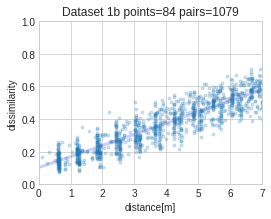

In [7]:
plt.style.use("seaborn-whitegrid")   
fig =  plt.figure(figsize=(4, 3))     # bc, realbc, iou   
m = np.polyfit([r[2] for r in bd] , [r[3] for r in bd], 2)
print(f"Slope = {m}")
predict = np.poly1d(m)
x_lin_reg = range(0, 8)
y_lin_reg = predict(x_lin_reg)
plt.plot(x_lin_reg, y_lin_reg, c = 'b', alpha=0.2, linewidth=3)

plt.plot([r[2] for r in bd] , [r[3] for r in bd], ".", label='bc', alpha=0.2)
plt.xlabel('distance[m]')
plt.ylabel('dissimilarity')
plt.grid(True)
plt.title(f"Dataset 1b points={len(etaje[0])} pairs={len(bd)}")
#plt.xticks(range(0, 20, 2))
plt.ylim(0, 1.0)
plt.xlim(0, 7.0)
#plt.yticks(np.arange(0, 1, 0.1))
#plt.legend(loc="upper left",shadow=True, fancybox=True)
plt.show()
fig.savefig(f"braycurtis-vs-distance-ds1b.svg", bbox_inches='tight')

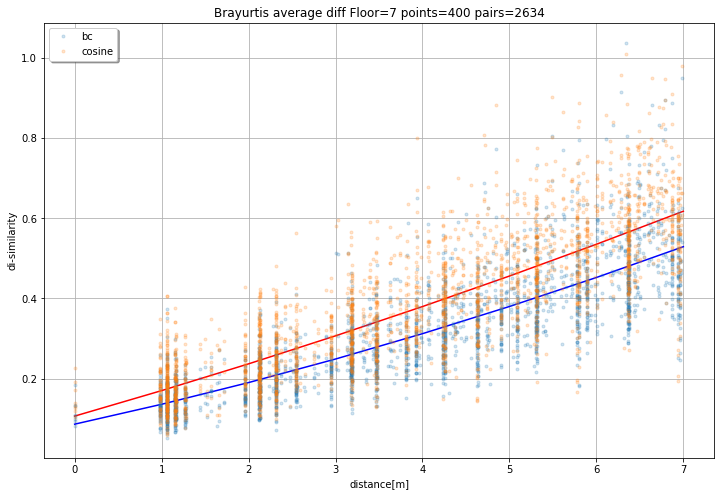
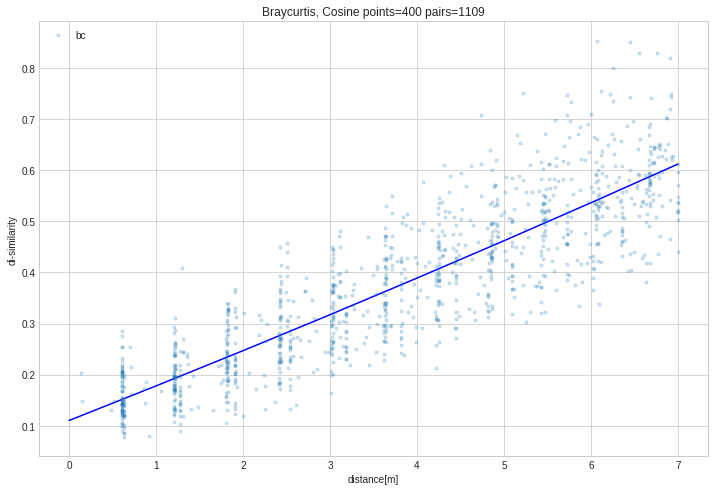



In [8]:
# Generate a matrix (list of lists) for a collection (etaj)
# [point_index, index_of_closest_pt, dist_to_closest_pt, index_diff, dist_2_best_neighbor]
def test_allvsall(collection, selection='Average'):
    lc = len(collection)
    #arr = [[0]*lc]*lc - nu merge!
    arr = [[0 for i in range(lc)] for j in range(lc)]
    for l in range(0, lc):
        for c in range(0, l):
            arr[l][c] = compare_locations(collection[l], collection[c], braycurtis, selection)
            arr[c][l] = arr[l][c]
        arr[l][l] = 1 # max 

   # print("#pt minpt mindist diff dist2nbr")
    listp = []
    for l in range(0, lc):
        mindist = min(arr[l])
        index_of_min = arr[l].index(mindist)
        diff = diff_modulo(l, arr[l].index(mindist), lc)
        distl=arr[l][(l-1+lc)%lc]
        distr=arr[l][(l+1)%lc]

        #print(l, index_of_min, mindist, diff, min(distl, distr))
        listp.append([l, index_of_min, mindist, diff, min(distl, distr)])
    return listp



def test_queryvsall(query, collections, selection='Average'):
    """
    query = collection, an array or fingerprints 
    collections = aray of collection, can be a floor  
    RETURNS (similarity, index, eu_distance)
    """
    min = 1000.0 
    mini = -1; 
    for c in range(0, len(collections)):
        d = compare_locations(query, collections[c], braycurtis, dif=True)
        if d != 0 and d < min:
            min = d 
            mini = c
    return min,mini, \
            euclidean([query['x'], query['y'], query['z']],\
                       [collections[mini]['x'], collections[mini]['y'],collections[mini]['z']])

  

In [118]:
# dissimilarities between signatures of the two phones at the SAME points

cl_sim = []
max_dissim = []
for nbr in [0, 1, 2, 3]:
        cl_sim.append([])
        max_dissim.append(0)
        for e in range(0, len(petaje)):
                for i in range(0, len(petaje[e])):
                        prev = (i - nbr + len(petaje[e])) % len(petaje[e])
                        next = (i + nbr ) % len(petaje[e])
                        dpr = compare_locations(petaje[e][i], retaje[e][next], braycurtis, dif=True) 
                        drp = compare_locations(petaje[e][i], petaje[e][prev], braycurtis, dif=True) 
                        #assert(dpr == drp)
                        max_dissim[nbr] = max(max_dissim[nbr], dpr, drp)
                        cl_sim[nbr].append(dpr)
                        cl_sim[nbr].append(drp)
                        #print(i, dpr, drp)
        print(f"Maximum dissimilarity({nbr}) = {max_dissim[nbr]}")
        print(f"CDF[{nbr}] 95/99/99.5 = {np.percentile(cl_sim[nbr], [95, 99, 99.5])}")

Maximum dissimilarity(0) = 0.3497395494815484
CDF[0] 95/99/99.5 = [0.22587757 0.28195994 0.3021363 ]
Maximum dissimilarity(1) = 0.3954086811926861
CDF[1] 95/99/99.5 = [0.25662261 0.31021028 0.31508286]
Maximum dissimilarity(2) = 0.4609732909407184
CDF[2] 95/99/99.5 = [0.31491189 0.38279471 0.39892764]
Maximum dissimilarity(3) = 0.499305040980911
CDF[3] 95/99/99.5 = [0.38295955 0.43929871 0.46613334]


## Similarity to the SAME point

PRECIS parter (dataset 1b)
Maximum dissimilarity = 0.2255335538412659
95% 99% 99.5% = 0.21447704 0.22478913 0.22553355]

PRECIS toate etajele (dataset 1a)
Maximum dissimilarity = 0.3497395494815484
95% 99% 99.5% = 0.24654021 0.30319051 0.32120967

## Similarity to NEARBY point - PRECIS parter (dataset 1b)
 - nearby at 0.6m left or right
Maximum dissimilarity = 0.2855485348746223
[0.20799245 0.2356736  0.25991684]
 - nearby at 1.2m left or right
Maximum dissimilarity = 0.30216521938304713
[0.24383523 0.27759673 0.29477282]
 - nearby at 1.8m left or right
Maximum dissimilarity = 0.31385697736926244
[0.26631109 0.30145173 0.30690545]
 - nearby at 2.4m left or right
Maximum dissimilarity = 0.3515687762528225
[0.3039745  0.33802126 0.34391539]

## Similarity to NEARBY point - PRECIS all (dataset 1a)



In [13]:
#  query = Pixel  
#  DB = redmi 
cl_sim = []
cl_steps = []
cl_dist = []
every = 3 # place documents every 6 steps (one step = 0.6m)
query = [np.roll(petaje[0], 0)[0::every]] 
db = [np.roll(retaje[0], 0)[0::every]] 
#for e in len(retaje):
for eq in range(0, len(query)): 
    for q in range(0, len(query[eq])):
        sim, index, d =  test_queryvsall(query[eq][q], db[eq], 'Average')
        print(q, query[eq][q]['x'], query[eq][q]['y'], sim, diff_modulo(q, index, len(petaje[eq])), d)
        cl_sim.append(sim)
        #cl_steps.append(diff_modulo(p, index, len(petaje[e])))
        cl_dist.append(d)

query = [np.roll(retaje[0], 0)[0::every]] 
db = [np.roll(petaje[0], 0)[0::every]] 
#for e in len(retaje):
for eq in range(0, len(query)): 
    for q in range(0, len(query[eq])):
        sim, index, d =  test_queryvsall(query[eq][q], db[eq], 'Average')
        print(q, query[eq][q]['x'], query[eq][q]['y'], sim, diff_modulo(q, index, len(petaje[eq])), d)
        cl_sim.append(sim)
        #cl_steps.append(diff_modulo(p, index, len(petaje[e])))
        cl_dist.append(d)



        
print(np.percentile(cl_dist, [50, 95, 99]))

0 41.61 20.44 0.19476205179322612 0 0.0
1 41.61 22.257 0.18371065761918162 0 0.0
2 41.61 24.074 0.10474179305130538 0 0.0
3 41.61 25.891 0.175549730150223 1 1.8180000000000014
4 41.61 27.709 0.14260570458740573 0 0.0
5 41.61 29.526 0.1684873211436245 1 1.8170000000000002
6 41.61 31.343 0.135320050472044 0 0.0
7 41.61 33.16 0.17081832510224762 1 1.8169999999999966
8 43.433 33.16 0.21447704183465852 0 0.0
9 45.256 33.16 0.19740082857770766 0 0.0
10 47.079 33.16 0.15364698931374643 1 1.8220000000000027
11 48.901 33.16 0.10878711921087714 0 0.0
12 50.724 33.16 0.1320858860132254 0 0.0
13 52.547 33.16 0.163321118491115 0 0.0
14 54.37 33.16 0.15521605101497088 1 1.8230000000000004
15 54.37 31.252 0.13264272217899611 1 1.9079999999999977
16 54.37 29.344 0.10872761249489525 0 0.0
17 54.37 27.436 0.14266936624562787 1 1.9080000000000013
18 54.37 25.528 0.11673581838999275 0 0.0
19 54.37 23.62 0.08571121219294416 0 0.0
20 54.37 21.712 0.11672073423498674 1 1.9080000000000013
21 53.539 20.438 0.1

In [14]:
print(len(retaje[0]))
#print(petaje[0][84]['x_p'], retaje[0][84]['x_p'])
print(test_queryvsall(retaje[0][20], petaje[0], 'Average'))

fromp = retaje[0][83]
top = petaje[0][83]
print(euclidean([fromp['x'], fromp['y'], fromp['z']],\
                       [top['x'], top['y'], top['z']]))
#print(json.dumps(retaje[0][67]))

84
(0.15229972836265768, 22, 0.8584287972802394)
0.0


precis-02 cross validation 
fbc + diff/adj  [0.608      1.67511104 2.24934528]

precis-01, cross validation 
fbc + diff/adj  [1.06       2.38321704 3.47432727]

real + True [0.98153846 2.12666667]
bc + True [0.98153846 2.12666667 2.55557152]


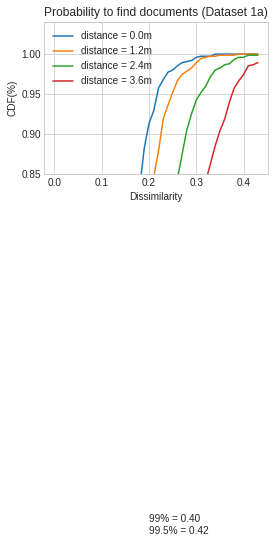

In [124]:
b = np.arange(0, 0.45, 0.01) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
cdf = []
for d in range(0, len(cl_sim)):
        hist_sim, bins_out = np.histogram(np.array(cl_sim[d]), b, density=False)
        hist_sim = hist_sim / len(cl_sim[d])
        cdf.append(np.cumsum(hist_sim))
fig = plt.figure(figsize=(4, 3))
# plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel("Dissimilarity")
plt.ylabel("CDF(%)")
plt.ylim(0.85, 1.04)
plt.title("{}{}".format("Probability to find documents (Dataset 1a)", ""))
for d in range(0, len(cl_sim)):
        plt.plot(b[:-1], cdf[d], label=f"distance = {d*1.2:.1f}m")
plt.grid(True)
plt.legend(loc="upper left",shadow=True, fancybox=True)
plt.tight_layout()
#plt.text(0.2, 0.4, f'99% = {np.percentile(cl_sim, [99])[0]:.2f}\n99.5% = {np.percentile(cl_sim, [99.5])[0]:.2f}')
plt.show()
fig.savefig(f"disim-samenbr-cdf-dataset1a.pdf", bbox_inches='tight')
fig.savefig(f"disim-samenbr-cdf-dataset1a.svg", bbox_inches='tight')

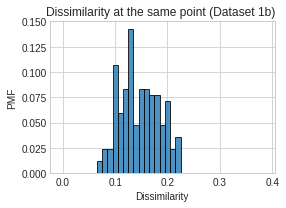

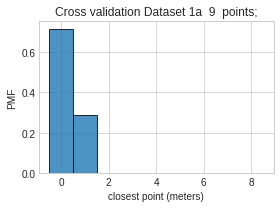

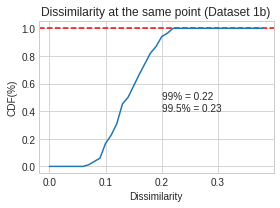

[0.14882324 0.21447704 0.22478913 0.22553355]


In [84]:

b = np.arange(0, 0.4, 0.01) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_sim), b, density=False)
hist_sim = hist_sim / len(cl_sim)
plt.style.use("seaborn-whitegrid")   
fig = plt.figure(figsize=(4, 3))
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("Dissimilarity")
plt.ylabel("PMF")
plt.title("{}{}".format("Dissimilarity at the same point (Dataset 1b)", " "))
plt.tight_layout()
plt.show()
fig.savefig(f"disim-same-dataset1b.pdf", bbox_inches='tight')
fig.savefig(f"disim-same-dataset1b.svg", bbox_inches='tight')
#    print("Percentages: ", hist_away)

bd = np.arange(0, 10, 1) # Bins of histogram - from 1 to 5 
bin_width = bd[1] - bd[0]
hist_dist, bins_out = np.histogram(np.array(cl_dist), bd, density=False)
hist_dist = hist_dist / len(cl_dist)
fig = plt.figure(figsize=(4, 3))
plt.bar(bd[:-1], hist_dist, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("closest point (meters)")
plt.ylabel("PMF")
plt.title("{} {} {}".format("Cross validation Dataset 1a ", len(hist_dist), " points;"))
plt.tight_layout()
plt.show()
fig.savefig(f"dist-closest-cross-dataset1b.pdf", bbox_inches='tight')
fig.savefig(f"dist-closest-cross-dataset1b.svg", bbox_inches='tight')
#    print("Percentages: ", hist_away)

cdf=np.cumsum(hist_sim)
fig = plt.figure(figsize=(4, 3))
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel("Dissimilarity")
plt.ylabel("CDF(%)")
plt.title("{}{}".format("Dissimilarity at the same point (Dataset 1b)", ""))
plt.plot(b[:-1], cdf)
plt.grid(True)
plt.tight_layout()
plt.text(0.2, 0.4, f'99% = {np.percentile(cl_sim, [99])[0]:.2f}\n99.5% = {np.percentile(cl_sim, [99.5])[0]:.2f}')
plt.show()
fig.savefig(f"disim-same-cdf-dataset1b.pdf", bbox_inches='tight')
fig.savefig(f"disim-same-cdf-dataset1b.svg", bbox_inches='tight')

print(np.percentile(cl_sim, [50, 95, 99, 99.5]))


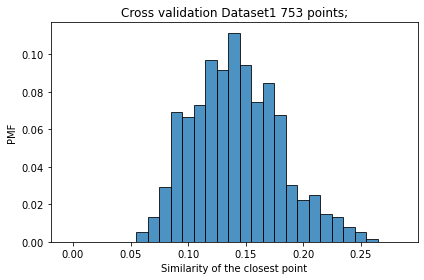
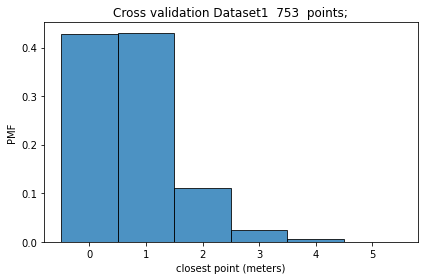
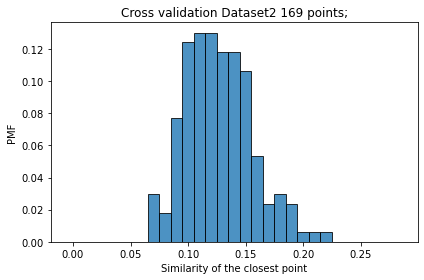
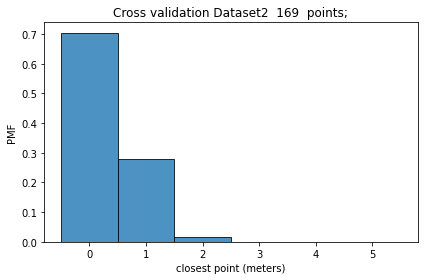
